In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from tqdm.notebook import trange

from utils import (
    load_oa_data,
    plot_circle_fitness,
    plot_hypervolume,
    plot_oa,
    set_matplotlib_style,
    singledim,
)

set_matplotlib_style()

# Multi-Objective Optimisation with NSGA-II

Part 0: Brief optimisation primer

Part 1: Maximum Coverage Location problems

Part 2: Genetic Algorithms

Part 3: Multi-Objective Optimisation with NSGA-II


# Part 0: Optimisation Problems

Problems where we have some "**_fitness function_**" $f(x)$ that we wish to maximise:

$$
\mathrm{max} f(x)
$$

given some "_**decision variables**_" $x$.

For example, perhaps we're designing a car and want to maximise its fuel economy ($f(x) =$ fuel economy), the decision variables $x$ may represent choices around:
- Engine capacity
- Vehicle weight
- Wheel size
- ...

Usually our choice of $x$ must also meet some "_**constraints**_":
$$
g(x) \leq 0 \\
h(x) = 0 \\
...
$$

For example, the cost of manufacturing the car may need to be kept below a certain value.

And each element of $x$, $x_i$, may need to be kept within certain "_**bounds**_":
$$
l_i \leq x_i < u_i
$$

## For this talk

Limit ourselves to problems where

- The decision variables $x$ are integers, e.g. `x = [0, 4, 2, 1]`

- Each element of $x$ is positive: $0 \leq x_i < u$ (for most examples here an index number to some feature we're turning on or off)

- No additional constraints

- In Part 2: Problems with multiple fitness functions (multi-objective problems)


## Algorithms

- [Wikipedia has at least one for every letter of the alphabet except X](https://en.wikipedia.org/wiki/Category:Optimization_algorithms_and_methods)

Nature of the fitness function(s) $f(x)$ can influence the choice:
   - Differentiable
   - Unimodal or multi-modal
   - Optimal solution known to be in certain range?
   - Deterministic, stochastic, discontinuities...
   - Single or multiple fitness functions (single or multi-objective)
   - Computational complexity (time to compute)

Here: Two types of genetic algorithm

# Part 1: Maximum Coverage Location Problems

## Camden

The home of the Turing Institute.

We're going to use some Census data on the the number of residents around Camden in each of its _**output areas**_ - the smallest regions available in the Census.

- Camden contains 749 output areas
- The size of an output area is related to how many people live there (i.e. more densely populated areas have smaller output areas)

In [2]:
oa_stats = load_oa_data()
oa_stats.head()

geometry           x  \
oa11cd                                                                     
E00004120  POLYGON ((526851.642 184658.668, 526860.889 18...  526950.068   
E00004121  POLYGON ((527000.000 184442.000, 527028.801 18...  527106.128   
E00004122  POLYGON ((527260.558 184350.205, 527230.487 18...  527115.064   
E00004123  POLYGON ((527230.487 184343.266, 527236.430 18...  527156.707   
E00004124  POLYGON ((527363.034 184852.968, 527385.983 18...  527455.828   

                    y  total_population  total_density  over65  \
oa11cd                                                           
E00004120  184692.611               388   17309.118526      68   
E00004121  184466.374               290   14732.584646      57   
E00004122  184356.700               294   11318.773408      36   
E00004123  184229.407               333   10192.806087      53   
E00004124  184942.683               184   10566.264307      31   

           over65_density  workers  workers_density  
oa11cd                                               
E00004120     3033.556855       72      3212.001376  
E00004121     2895.714913       38      1930.476609  
E00004122     1385.972254       38      1462.970713  
E00004123     1622.278446       69      2112.022883  
E00004124     1780.185834       22      1263.357689

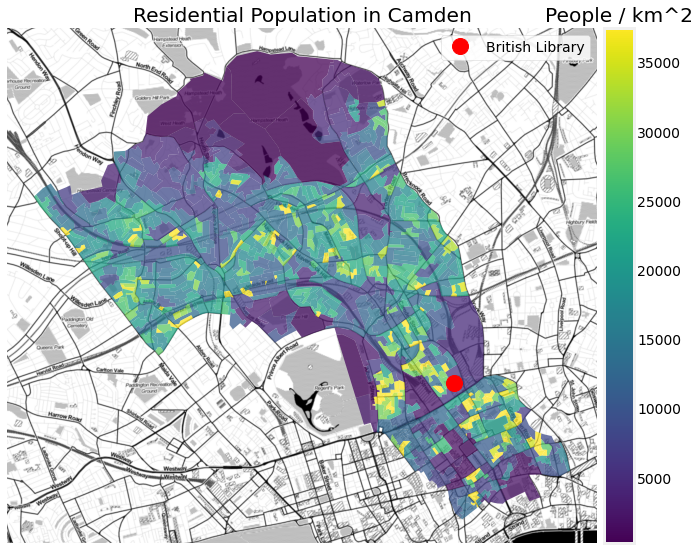

In [3]:
plot_oa(
    oa_stats["total_density"],
    vmax=37500,
    legend=True,
    cax_label="People / km^2",
    title="Residential Population in Camden",
)

## Example: Ice Cream Mogul

Wants to dominate the ice cream market in Camden.

![](figs/ice_cream_owner.jpg)

## Maximum Coverage Location Problem

Step 1 to ice cream domination: Send ice cream stands to 20 locations in Camden.

But where?

Place stands to maximise the number of "covered" residents.

![](figs/camden_stands.jpg)

## Defining Coverage

A site (output area) is covered if there is a facility (ice cream stand) within a distance $r$.

Binary - each site is either covered or not.

Simplification:
- Each site (output area) is represented by a single point
- Facilities (ice cream stands) are also placed at those points (set of site and facility locations is the same)

### Covered Locations Class

Instantiated with:
- A 2D array of points (x and y position, size $k \times 2$ where $k$ is the number of points/sites)
- Radius that a placed facility covers
- Optionally, a weight for each point

Contains:
- A "coverage matrix" (size $k \times k$) - encodes which points would be covered by placing a facility at any point.

Provides:
- Coverage `fitness` function
   - Input: Indices of points where facilities are placed.
   - Output: (Weighted) fraction of points that are covered by those facilities.

In [4]:
class CoveredLocations:
    def __init__(self, points, radius, weights=None):
        self.coverage_matrix = self._compute_matrix(points, radius)
        self.n_points = points.shape[0]
        self.weights = weights

    def _compute_matrix(self, points, radius):
        dist_sq = np.sum(
            (points[:, np.newaxis, :] - points[np.newaxis, :, :]) ** 2, axis=-1
        )
        return np.sqrt(dist_sq) < radius

    @singledim
    def covered_points(self, site_idx):
        # bool matrix of shape number solutions (site_idx.shape[0]) * n_points
        # true if point has a site (ice cream stand) in the candidate solution
        if site_idx.ndim == 1:
            site_idx = site_idx[np.newaxis, :]
        n_solutions = site_idx.shape[0]
        site_matrix = np.full((n_solutions, self.n_points), False)
        site_matrix[np.arange(n_solutions)[:, np.newaxis], site_idx] = True

        # for each solution, whether each point is covered by any site (ice cream stand)
        covered_points = np.full((n_solutions, self.n_points), False)
        for s in range(n_solutions):
            covered_points[s, :] = self.coverage_matrix[:, site_matrix[s, :]].any(
                axis=1
            )

        return covered_points

    @singledim
    def fitness(self, site_idx):
        covered = self.covered_points(site_idx)
        if self.weights is not None and self.weights.ndim > 1:
            return np.array(
                [
                    np.average(covered, weights=self.weights[:, i], axis=1)
                    for i in range(self.weights.shape[1])
                ]
            ).T
        return np.average(covered, weights=self.weights, axis=1)

### Example: Coverage of points along a straight line

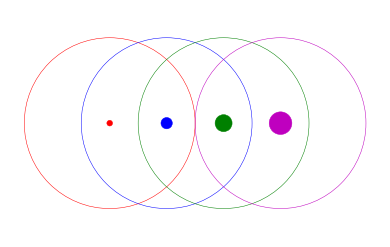

In [5]:
points = np.array([[0, 0], [2, 0], [4, 0], [6, 0]])  # x and y coordinate for each point
weights = np.array([1, 2, 3, 4])  # weight for each point
radius = 3

fig, ax = plt.subplots(1, 1)
colors = ["r", "b", "g", "m"]
for col, mid in zip(colors, points):
    ax.add_patch(plt.Circle(mid, radius=radius, edgecolor=col, facecolor="None"))
ax.scatter(points[:, 0], points[:, 1], s=32 * weights**2, c=colors)
ax.axis("equal")
ax.axis("off");

In [6]:
cl = CoveredLocations(points, radius, weights)
print(cl.coverage_matrix)

[[ True  True False False]
 [ True  True  True False]
 [False  True  True  True]
 [False False  True  True]]


In [7]:
# Two 'solutions' - one with a facility placed at point index 0 and 1,
# second with a site placed at point index 1 and 2
site_idx = np.array([[0, 1], [1, 2]])

# Which points are covered by the placed facilities in each solution
print("Points covered in each solution:")
print(cl.covered_points(site_idx))
print()

# Overall coverage provided by each solution (taking into account weights)
print("Overall coverage of each solution:")
print(cl.fitness(site_idx))

Points covered in each solution:
[[ True  True  True False]
 [ True  True  True  True]]

Overall coverage of each solution:
[0.6 1. ]


## Coverage Applied to Camden

### Population-Weighted Centroids

Representative location for each output area.

Better captures where people live in an output area than geometric centre.

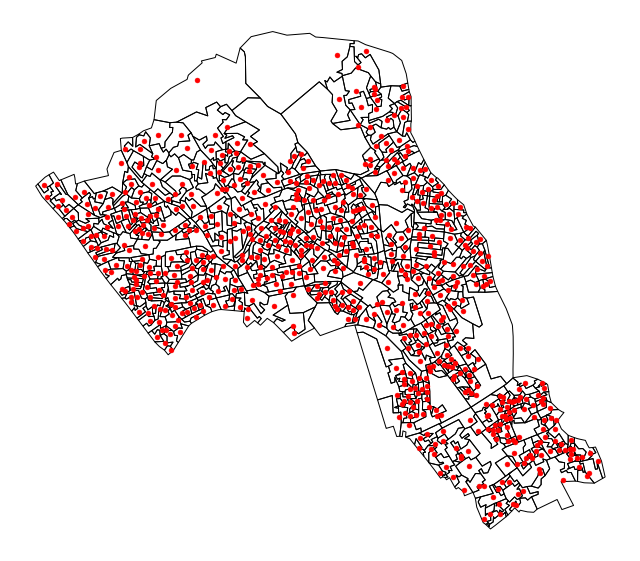

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_oa(ax=ax, show_bl=False, basemap=False)
ax.scatter(oa_stats["x"], oa_stats["y"], color="r", s=24)

### Example: Coverage from a single ice cream stand


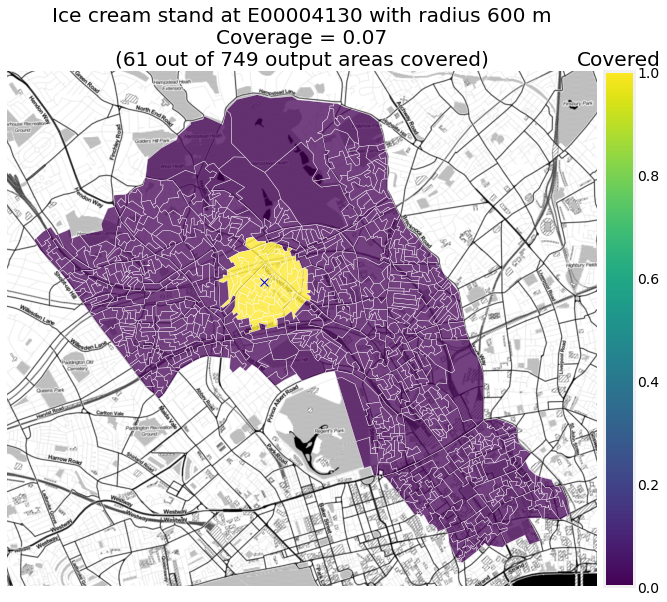

In [9]:
radius = 600
cl = CoveredLocations(
    oa_stats[["x", "y"]].values, radius, weights=oa_stats["total_population"].values
)

# place a ice cream stand in the output area with index 10
site_idx = np.array([10])

fig, ax = plt.subplots(figsize=(10, 10))
title = (
    f"Ice cream stand at {oa_stats.index[10]} with radius {radius} m\n"
    f"Coverage = {cl.fitness(np.array([10]).reshape(1, 1))[0]:.2f}\n"
    f"({cl.covered_points(site_idx).sum()} out of {len(oa_stats)} output areas covered)"
)
plot_oa(
    cl.covered_points(site_idx),
    ax=ax,
    show_bl=False,
    title=title,
    legend=True,
    cax_label="Covered",
    edgecolor="w",
)
ax.plot(
    oa_stats["x"].values[site_idx], oa_stats["y"].values[site_idx], "bx", markersize=8
)

## The Ice Cream Stand Optimisation Problem

Coverage of output area $a$ with a set of ice cream stands $\mathcal{S}$:

$$
  c(a, \mathcal{S}) =
  \begin{cases}
    1,& \text{if } \min\limits_{s \in \mathcal{S}}d(a, s) < r \\
    0 & \text{otherwise}
  \end{cases}
$$

where $s$ is one of the output areas containing an ice cream stand ($s \in \mathcal{S}$), $d(a, s)$ is the distance between the population-weighted centroids of $a$ and $s$, and $r$ is the assumed coverage radius of each ice cream stand.

We wish to maximise the fraction of residents our ice cream stands cover, given by:

$$
C(\mathcal{S}) = \frac{\sum_{a \in \mathcal{A}} w_a c(a, \mathcal{S})}{\sum_{a \in \mathcal{A}} w_a}
$$

where $w_a$ is the number of residents in output area $a$.



A set of ice cream stands $\mathcal{S}$ is represented by an array of length $k$, where $k$ is the number of ice cream stands (number of _decision variables_).

Each individual ice cream stand $s \in \mathcal{S}$ is represented by an integer $0 \leq s < |\mathcal{A}|$, where $|\mathcal{A}|$ is the number of output areas in Camden.

i.e. a set of ice cream stand placements is represented by an array of output area indices, e.g. `S = [115, 64, 3]` places an ice cream stand at output area indices 115, 64, 3.

# Part 2: Genetic Algorithms

A class of optimisation algorithms where:
- We start with an initial _population_ of candidate solutions
- The population is iteratively improved
- The way we improve the population is inspired by natural selection
   - Competition
   - Breeding (combining parent solutions to create a child solution)
   - Random mutations
   - Survival of the fittest


## When to use?

Pros:
- Work without gradient information
- Can explore multi-modal fitness functions
- Return multiple candidate solutions
- Variants for multi-objective problems

Cons:
- If gradient information is available other approaches may work better/faster
- Relies on computing fitness function many times - slow if $f(x)$ is computationally complex

Note: Genetic algorithms are a type of _Evolutionary Algorithm_.

## Initial Population

Consider a random set of monsters:

![](figs/initial_population.jpg)

In our actual problems, the "decision variables" (e.g. the shape, size, eye type, ... of the monsters) are represented by arrays of integers. We start with a random population of integers uniformly sampled between a minimum and maximum value (the bounds):

In [10]:
def init_population(shape, bounds):
    return np.random.randint(bounds[0], bounds[1], size=shape)


pop = init_population((4, 5), (0, 21))
pop

array([[ 4,  1, 18, 19, 16],
       [ 5,  4,  2, 14,  3],
       [20,  5,  2, 15, 14],
       [16,  6, 11,  1,  6]])

The population array has size $n \times k$, where $n$ is the number of candidate solutions (number of monsters) it contains, and $k$ is the number of decision variables.


We compute a fitness score for each member of the initial population (these are the values under the monsters above):

In [11]:
fitness = np.array([3.0, 4.0, 1.0, 2.0])

The fitness array has shape $n \times 1$.

## Selection

First step is to "_**select**_" groups of parents that will later be combined to create new child solutions.

One way of doing this is **Tournament Selection**:
- We have $n$ "fights" between members of the population (between monsters)
- Each fight has two competitors (by default)
- The competitors are randomly selected from the population _(with replacement)_
- The winner of each fight is the competitor with the highest fitness value
- We pair up the winners to create breeding pairs of parents

Note that:
- All candidates have an equal probability of appearing in a fight (irrespective of fitness)
- But the fittest monster in each fight always wins

![](figs/selection.jpg)

An example implementation:

In [12]:
class TournamentSelection:
    def __init__(self, n_battles=None, n_per_battle=2):
        self.n_battles = n_battles
        self.n_per_battle = n_per_battle

    def _select_winners(self, battle_idx, fitness):
        battle_fitness = fitness[battle_idx]
        return battle_fitness.argmax(axis=1)

    def _population_size(self, fitness):
        return len(fitness)

    def apply(self, fitness):
        population_size = self._population_size(fitness)
        n_battles = self.n_battles or population_size
        battle_idx = np.random.choice(
            np.arange(population_size), size=(n_battles, self.n_per_battle)
        )
        battle_winner = self._select_winners(battle_idx, fitness)
        return battle_idx[np.arange(population_size), battle_winner]

In [13]:
ts = TournamentSelection()

print("Fitness:", fitness)
print("Selected Idx:", ts.apply(fitness))

Fitness: [3. 4. 1. 2.]
Selected Idx: [1 1 0 1]


## Crossover

The next step is to combine the previously selected parents to create new child solutions.

One of the simplest ways to do this is **Single Point Crossover** where we, for each pair of parents:
- Randomly pick an index, $0 \leq i < k$
- Swap all the decision variable values up to index $i$ between the two parents
- This creates two new child solutions for each pair of parents

![](figs/crossover.jpg)

Example implementation:

In [14]:
class SinglePointCrossover:
    def __init__(self, prob=1.0):
        self.prob = prob

    def _get_crossover_flag(self, n):
        if self.prob == 1.0:
            return np.full(n, True)

        return np.random.random(n) < self.prob

    def _get_points(self, population_size, n_vars):
        return np.random.randint(1, n_vars, size=population_size // 2)

    def _get_children(self, population, points, do_cross):
        population_size, n_vars = population.shape
        children = np.copy(population)
        for idx in range(0, population_size - 1, 2):
            if do_cross[idx // 2]:
                cross_idx = points[idx // 2]
                children[idx, cross_idx:] = population[idx + 1, cross_idx:]
                children[idx + 1, cross_idx:] = population[idx, cross_idx:]
        return children

    def apply(self, population):
        population_size, n_vars = population.shape

        # crossover locations
        points = self._get_points(population_size, n_vars)

        # crossover occurs with probability prob (if no crossover children same as parents)
        do_cross = self._get_crossover_flag(population_size // 2)

        # make children from 2 parents
        return self._get_children(population, points, do_cross)

In [15]:
population = np.array(
    [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20]]
)
spc = SinglePointCrossover()
spc.apply(population)

array([[ 1,  7,  8,  9, 10],
       [ 6,  2,  3,  4,  5],
       [11, 12, 18, 19, 20],
       [16, 17, 13, 14, 15]])

## Mutation

Add random perturbations to children with some probability (by default $1/k$):

![](figs/mutation.jpg)

Example implementation, where mutations are uniformly sampled from the bounds (i.e. a random integer between 0 and $k$):

In [16]:
class UniformMutation:
    def __init__(self, bounds, prob=None):
        self.bounds = bounds
        self.prob = prob

    def apply(self, population):
        prob = self.prob or 1 / population.shape[0]
        mutate_mask = np.random.random(size=population.shape) < prob
        mutate_values = np.random.randint(
            self.bounds[0], self.bounds[1], size=population.shape
        )
        population[mutate_mask] = mutate_values[mutate_mask]
        return population

In [17]:
um = UniformMutation(bounds=(0, 21), prob=0.4)
x = np.array([1, 2, 3, 4, 5])
um.apply(x)

array([1, 5, 3, 4, 5])

## Survival

We now have a population of size $2n$ containing the $n$ candidates from the initial population and $n$ children. We select $n$ of these to survive to the next generation.

One way is to apply _**elitism**_, the fittest $n$ candidates amongst the initial population and the children survive (we'll see a different choice in Part 2):

![](figs/updated_population.jpg)

## Genetic Algorithm

- Create initial population, with $n$ candidate solutions.
- Loop for $g$ generations:
  - Selection: Select pairs of parents from population
  - Crossover: Combine parents to create children
  - Mutation: Randomly perturbate children
  - New population: Keep best $n$ solutions from initial population and children
  
Example implementation:
- `GeneticAlgorithm` class instantiated with
   - An initial `population` ($n \times k$ NumPy array)
   - A `fitness` function (takes a population as its only argument, returns one value for each candidate)
   - A `selection` instance (has an apply method which takes fitness scores as its only input, returns the indices for $n$ selected parents)
   - A `crossover` instance (has an apply method that takes the parents, a $n \times k$ array, as inputs and returns child solutions, a new $n \times k$ array)
   - A `mutation` instance (has an apply method that takes a population and returns a mutated population)
- `update` function applies all the genetic operators to update the population once
- `run` function runs the update for a given number of generations
- Keeps track of the history of the fitness scores

In [18]:
class GeneticAlgorithm:
    def __init__(
        self,
        population,
        fitness,
        selection,
        crossover,
        mutation,
        duplicates=None,
        metrics=None,
    ):
        self.population = population
        self.population_size = population.shape[0]
        self.fitness = fitness
        self.fitness_scores = self.fitness(self.population)
        self.selection_scores = self.fitness_scores

        self.selection = selection
        self.crossover = crossover
        self.mutation = mutation
        self.duplicates = duplicates
        self.metrics = metrics

        self.fitness_log = [self.max_fitness]
        if self.metrics is not None:
            self.metrics_log = [self.metrics(self.fitness_scores)]
        self.generations_ran = 0

    def _breed(self):
        # Selection - create a new pool of parent solutions from the current population
        parents = self.population[self.selection.apply(self.selection_scores), :]
        # Crossover - combine the parents to create new child solutions
        children = self.crossover.apply(parents)
        # Mutation - make random modifications to the child solutions
        return self.mutation.apply(children)

    def _survival(self, new_scores):
        # keep the best `population_size` solutions out of parents & children
        self.selection_scores = self.fitness_scores
        return np.argsort(new_scores)[-self.population_size :]

    def update(self):
        children = self._breed()  # apply genetic operators

        new_population = np.concatenate((self.population, children))
        new_scores = np.concatenate((self.fitness_scores, self.fitness(children)))

        if self.duplicates is not None:
            new_scores, new_population = self.duplicates.apply(
                new_scores, new_population
            )

        best_idx = self._survival(new_scores)
        self.fitness_scores = new_scores[best_idx]
        self.population = new_population[best_idx, :]

        self._update_logs()
        self.generations_ran += 1

    def run(self, generations):
        for _ in trange(generations):
            self.update()

    def _update_logs(self):
        self.fitness_log.append(self.max_fitness)
        if self.metrics is not None:
            self.metrics_log.append(self.metrics(self.fitness_scores))

    @property
    def max_fitness(self):
        return self.fitness_scores.max()

    def champion(self):
        return self.population[self.fitness_scores.argmax(), :]

## Example: Maximise Sum

Consider an initial population of values between 0 and 10 (10 rows/candidate solutions and 5 columns/decision variables):

In [19]:
initial_pop = init_population(shape=(10, 5), bounds=(0, 10))
print(initial_pop)

[[5 6 5 0 4]
 [0 0 0 5 5]
 [1 2 3 8 7]
 [7 8 8 3 8]
 [6 9 7 8 2]
 [3 9 1 4 8]
 [7 6 2 1 5]
 [2 6 0 5 1]
 [0 6 7 3 9]
 [1 3 8 6 2]]


Let's define the fitness to be the sum of the values:

In [20]:
def sum_fitness(population):
    return population.sum(axis=1)


print("Max initial sum:", sum_fitness(initial_pop).max())
print("Min initial sum:", sum_fitness(initial_pop).min())

Max initial sum: 34
Min initial sum: 10


And then use the Genetic Algorithm to maximise it:

In [21]:
ts = TournamentSelection()
spc = SinglePointCrossover()
um = UniformMutation(bounds=(0, 10))
ga = GeneticAlgorithm(
    initial_pop, fitness=sum_fitness, selection=ts, crossover=spc, mutation=um
)

print("Initial population:")
print(initial_pop)
print("Max initial sum:", sum_fitness(initial_pop).max())
print("Min initial sum:", sum_fitness(initial_pop).min())

for gen in [1, 5, 50]:
    ga.run(gen)
    print(f"After {ga.generations_ran} generations:")
    print(ga.population)
    print("Max sum:", ga.max_fitness)
    print("Min sum:", ga.fitness_scores.min())

Initial population:
[[5 6 5 0 4]
 [0 0 0 5 5]
 [1 2 3 8 7]
 [7 8 8 3 8]
 [6 9 7 8 2]
 [3 9 1 4 8]
 [7 6 2 1 5]
 [2 6 0 5 1]
 [0 6 7 3 9]
 [1 3 8 6 2]]
Max initial sum: 34
Min initial sum: 10


  0%|          | 0/1 [00:00<?, ?it/s]

After 1 generations:
[[0 6 7 3 9]
 [2 6 3 8 7]
 [3 6 7 3 9]
 [7 9 1 4 8]
 [3 8 8 3 8]
 [6 9 7 8 2]
 [6 9 7 8 2]
 [3 9 9 8 4]
 [7 8 8 3 8]
 [5 8 8 7 8]]
Max sum: 36
Min sum: 25


  0%|          | 0/5 [00:00<?, ?it/s]

After 6 generations:
[[7 8 8 8 9]
 [8 9 7 8 8]
 [9 8 7 8 8]
 [9 8 7 8 8]
 [7 9 8 9 8]
 [9 9 7 8 8]
 [8 8 9 8 8]
 [8 9 7 8 9]
 [8 9 8 9 8]
 [8 9 8 9 8]]
Max sum: 42
Min sum: 40


  0%|          | 0/50 [00:00<?, ?it/s]

After 56 generations:
[[9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]]
Max sum: 45
Min sum: 45


Note that:
- Can see how initial solutions are preserved/modified at the start
- After 50ish generations usually get the best possible result
- The _diversity_ of the population decreases as we progress (which may cause problems in some cases, in Part 2 we'll see a diversity-preserving approach)

## Back to Camden: Results

Place 20 ice cream stands to maximise the number of residents covered. Start with 100 randomly generated locations for the 20 stands:

In [22]:
population_size = 100
n_oa = len(oa_stats)
n_ice_cream = 20

pop = init_population((population_size, n_ice_cream), (0, n_oa))

and let's say that people within 300 metres of our ice cream stands will be enticed to come:

In [23]:
radius = 300
cl = CoveredLocations(
    oa_stats[["x", "y"]].values, radius, weights=oa_stats["total_population"].values
)

Then this this the best candidate solution out of our initial population:

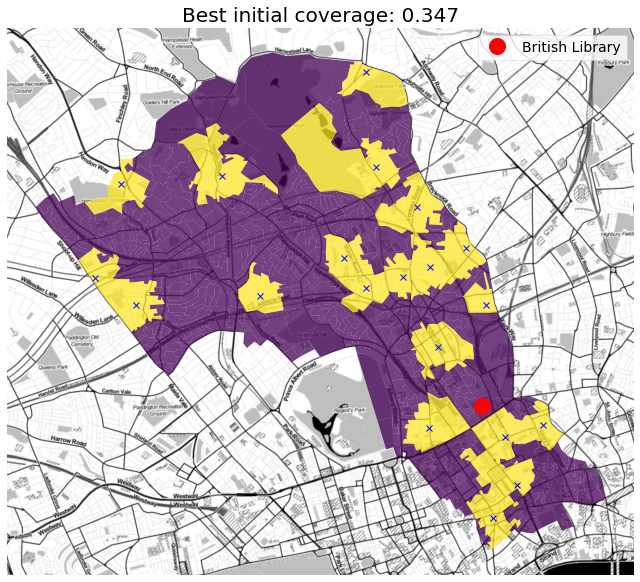

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
best_init = cl.fitness(pop).argmax()
plot_oa(
    cl.covered_points(pop[best_init, :]),
    ax=ax,
    title=f"Best initial coverage: {cl.fitness(pop).max():.3f}",
)
ax.plot(
    oa_stats["x"].values[pop[best_init, :]],
    oa_stats["y"].values[pop[best_init, :]],
    "bx",
);

Run the genetic algorithm for 2500 generations:

  0%|          | 0/2500 [00:00<?, ?it/s]

Text(0, 0.5, 'fitness')

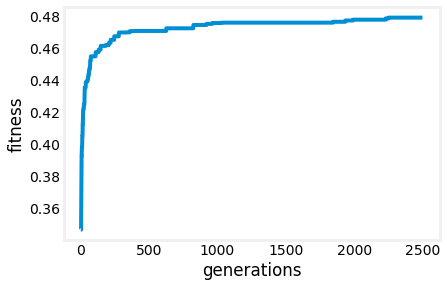

In [25]:
ts = TournamentSelection()
spc = SinglePointCrossover()
um = UniformMutation(bounds=(0, n_oa))
ga = GeneticAlgorithm(pop, fitness=cl.fitness, selection=ts, crossover=spc, mutation=um)
gen = 2500
ga.run(gen)
plt.plot(ga.fitness_log)
plt.xlabel("generations")
plt.ylabel("fitness")

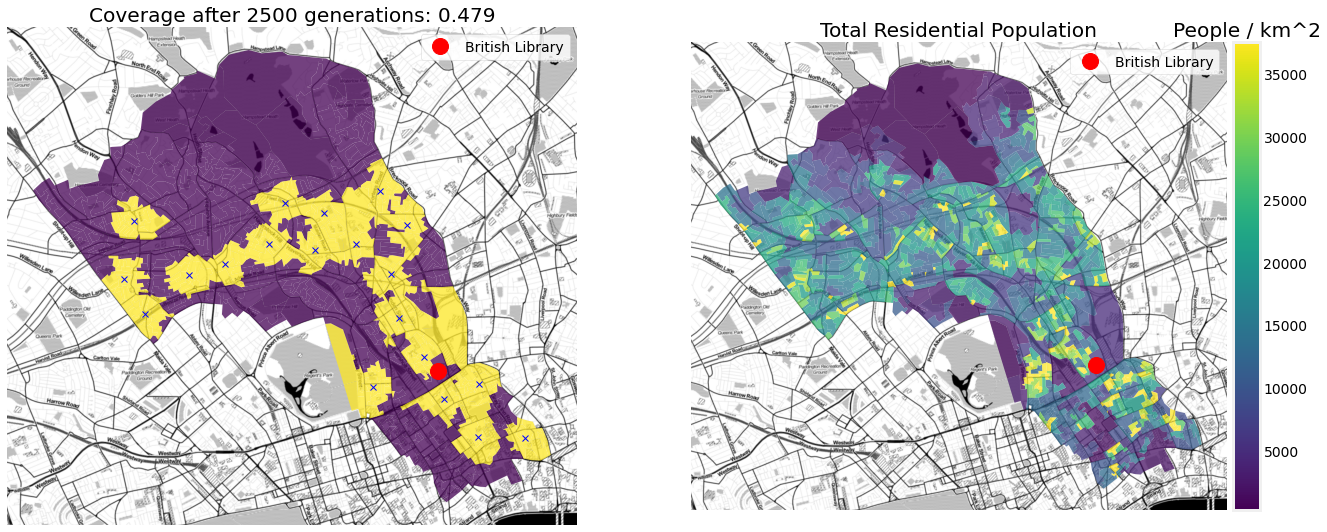

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
plot_oa(
    cl.covered_points(ga.champion()),
    ax=ax[0],
    title=f"Coverage after {gen} generations: {ga.max_fitness:.3f}",
)
ax[0].plot(
    oa_stats["x"].values[ga.champion()], oa_stats["y"].values[ga.champion()], "bx"
)

plot_oa(
    oa_stats["total_density"],
    vmax=37500,
    legend=True,
    cax_label="People / km^2",
    title="Total Residential Population",
    ax=ax[1],
)

# Part 3: Multi-objective Optimisation with NSGA-II

## Customer Research

Turns out all the people coming to buy our ice cream seem to come from two different groups:
- People over 65 years old
- People from nearby workplaces

![](figs/ice_cream_holders.jpg)

## Where are Over 65s and Workers?

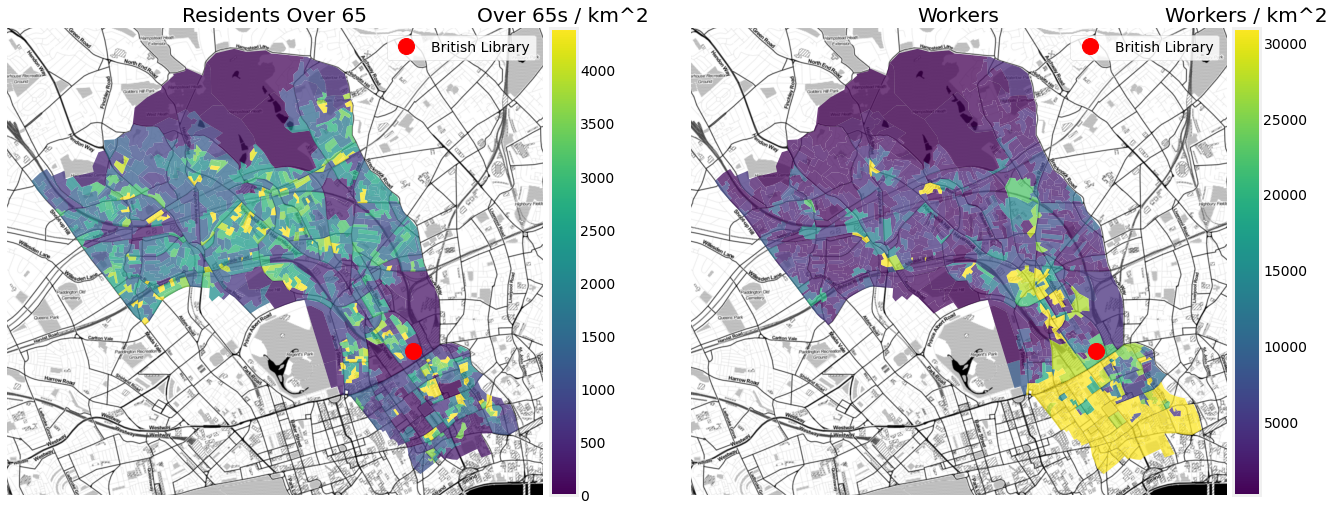

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_oa(
    oa_stats["over65_density"],
    vmax=4400,
    legend=True,
    cax_label="Over 65s / km^2",
    ax=ax[0],
    title="Residents Over 65",
)

plot_oa(
    oa_stats["workers_density"],
    vmax=31000,
    legend=True,
    cax_label="Workers / km^2",
    ax=ax[1],
    title="Workers",
)

## Re-Formulating the Problem: Multi-Objective Optimisation

- Where should ice cream stands be placed to cover as many residents over 65 and workplaces as possible?
- It's not possible to maximise both - the optimal solution for workers only will be different to one for over 65s only
- Need to decide how to compromise between the two:
   - Approach 1: Pick a weighting factor for each and combine them into a single objective (single-valued fitness function), i.e. decide how this should be done _**before**_ running the optimisation.
   - Approach 2: Run a multi-objective optimisation (i.e. with multiple fitness functions) that attempts to find all possible "optimal" compromise solutions. Then decide which compromise to pick _**after**_ running the optimisation.
   
We're going to look at Approach 2 here.

## What's an optimal compromise?

Consider the figure below:
- Each circle  (red or grey) represents a possible solution to the problem
- The fitness value of each solution for two objectives is plotted (_"quantity of item 1"_ on the x-axis, and _"quantity of item 2"_ on the y-axis)

![](figs/pareto_front.png)

Figure: [_Wikimedia Commons: A Pareto Optimal Front, illustrated using a production-possibility frontier, 2014, Njr00, CC BY-SA 3.0_](https://commons.wikimedia.org/wiki/File:Pareto_Efficient_Frontier_1024x1024.png)

The solutions in red (A-H) are _**"Pareto optimal"**_:
- No solution exists that increases the value of one objective without decreasing the value of the other objective
- E.g. solution _N_ is not Pareto optimal as solution _E_ _**dominates**_ it
   - Solution _E_ has a higher quantity of both item 1 and item 2 than solution _N_


We want to find solutions that lie on the _**"Pareto Front"**_ (the red line), or in other words we want to find _**non-dominated**_ solutions.

**Caveat:** We generally can't guarantee we've found the true Pareto front (there may be some other solution Z we haven't found that dominates one of the solutions A-H)


## The New Ice Cream Stand Problem

1. Find "non-dominated" placements of ice cream stands (such that it's not possible to move one without decreasing coverage of residents over 65 and/or workers).

2. Find placements cover a wide range of possible compromises between Over 65s and Workers coverage (i.e. span as much of the Pareto Front as possible).

3. (Not discussed here) Assess the candidate placements and select one to use.

## NSGA-II: Non-dominated Sorting Genetic Algorithm II

- NSGA-II is a _genetic algorithm_
   - Still the same core loop of selection, crossover, mutation and survival (starting from an initial population)
- It's a _multi-objective_ optimisation algorithm
   - It searches for solutions that span the Pareto front
- This is achieved by replacing selection and survival based only on max fitness with:
   - _**Non-dominated sorting**_
   - _**Crowding distance**_

So, generate children and then from the new population of parents and children choose the following to survive:
- Genetic algorithm - Keep the $n$ solutions with the highest fitness values (elitism).
- NSGA-II - Keep the $n$ solutions with the best _**non-dominance and crowding rank**_.

## Non-Dominated Sorting

Consider we have a population of fitness values for two objectives that looks like this:

Text(0, 0.5, 'Objective 2')

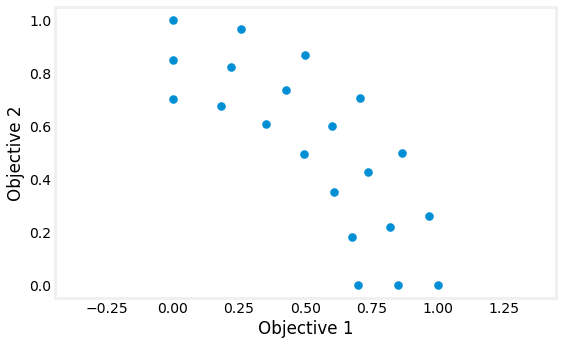

In [28]:
plt.figure(figsize=(8, 5))
n_front = 7
t = np.linspace(0, np.pi / 2, n_front)
x = []
y = []
for r in np.linspace(0.7, 1, 3):
    x.append(r * np.cos(t))
    y.append(r * np.sin(t))

x = np.concatenate(x)
y = np.concatenate(y)
fitness_values = np.array([x, y]).T

plt.scatter(x, y, s=64)
plt.axis("equal")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")

We want to pick the 10 solutions to keep for the next generation by their non-dominance and crowding rank. Let's start with non-dominance.

This function creates a matrix of which solutions each solution dominates (has larger than or equal fitness values for both objectives):

In [29]:
def dominates(fitness):
    n_scores = fitness.shape[0]
    fit1 = fitness.repeat(n_scores, axis=0)
    fit2 = np.tile(fitness, (n_scores, 1))
    dominates = (fit1 >= fit2).all(axis=1).reshape(n_scores, n_scores)
    not_same = (fit1 != fit2).any(axis=1).reshape(n_scores, n_scores)
    return np.logical_and(dominates, not_same)

Taking a sum along the columns gives a count of how many other solutions each solution is dominated by:

In [30]:
dominates(fitness_values).sum(axis=0)

array([7, 5, 3, 4, 3, 5, 7, 3, 2, 1, 1, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0])

(-0.05, 1.05)

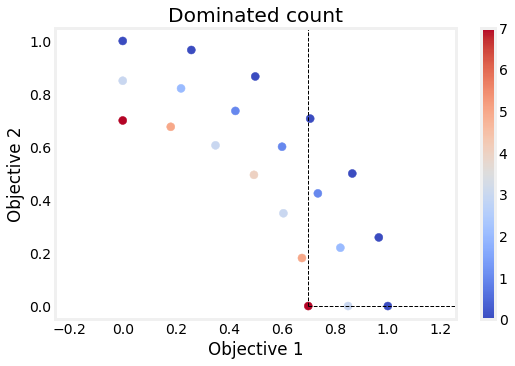

In [31]:
plt.figure(figsize=(8, 5))
plt.scatter(x, y, c=dominates(fitness_values).sum(axis=0), cmap="coolwarm", s=64)
plt.axis("equal")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.colorbar()
plt.title("Dominated count")

plt.vlines(x[0], y[0], 1.5, color="k", linestyle="--", linewidth=1)
plt.hlines(y[0], x[0], 1.5, color="k", linestyle="--", linewidth=1)
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

The red point at the bottom is dominated by all the solutions in/on the rectangle bounded by the dashed lines (and there are 7 of them). 

These counts let us define the first _**non-dominated front**_: solutions that are not dominated by another solution.

Now we exclude points on the first front and find points on the _second_ front (solutions that are only dominated by solutions on the first front):

Text(0.5, 1.0, 'Dominated count: Excluding First Front')

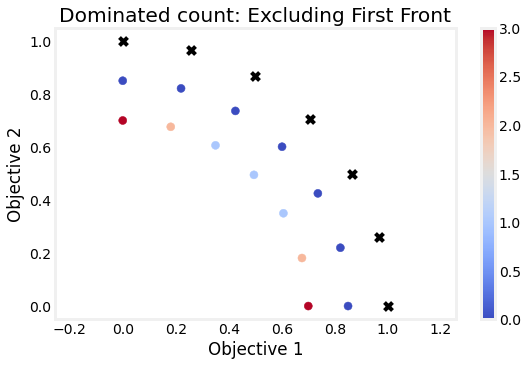

In [32]:
plt.figure(figsize=(8, 5))
plt.scatter(x[-n_front:], y[-n_front:], c="k", marker="x", s=64)
plt.scatter(
    x[:-n_front],
    y[:-n_front],
    c=dominates(fitness_values[:-n_front, :]).sum(axis=0),
    cmap="coolwarm",
    s=64,
)
plt.axis("equal")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.colorbar()
plt.title("Dominated count: Excluding First Front")

Until all the candidate solutions are assigned to a front:

In [33]:
def non_dominated_sort(fitness, n_stop=None):
    dominance_matrix = dominates(fitness)
    n_dominated = dominance_matrix.sum(axis=0)

    front_ranks = np.full(fitness.shape[0], -1)
    rank = 0
    front_idx = np.nonzero(n_dominated == 0)[0]
    front_ranks[front_idx] = rank
    n_sorted = len(front_idx)
    if n_stop is None:
        n_stop = fitness.shape[0]
    while n_sorted < n_stop:
        # decrement counter of solutions on previous front to exclude from future fronts
        n_dominated[front_idx] -= 1
        rank += 1

        next_front = set()
        for p in front_idx:
            dominated_by_p = np.nonzero(dominance_matrix[p, :])[0]
            n_dominated[dominated_by_p] -= 1
            next_front.update(np.nonzero(n_dominated == 0)[0])

        next_front = list(next_front)
        front_ranks[next_front] = rank
        n_sorted += len(next_front)
        front_idx = next_front

    return front_ranks

Front indices: [2 2 2 2 2 2 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


Text(0, 0.5, 'Objective 2')

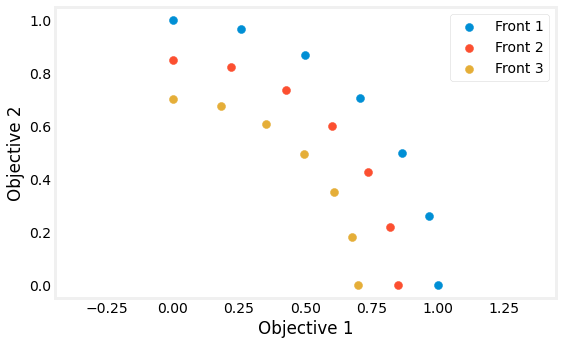

In [34]:
fronts = non_dominated_sort(fitness_values)
print(f"Front indices: {fronts}")

plt.figure(figsize=(8, 5))
for i in range(fronts.max() + 1):
    plt.scatter(
        fitness_values[fronts == i, 0],
        fitness_values[fronts == i, 1],
        label=f"Front {i+1}",
        s=64,
    )

plt.legend()
plt.axis("equal")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")

Which solutions should we keep for the next generation?
- Select by non-dominated front (from lowest front rank to highest).
- Keep all solutions on the first fronts, until the front that would take the number of solutions included above $n$.
- Keep _some_ solutions from that front by crowding distance (see below).

In the example above, where we want to keep 10 solutions:
- Include all 7 solutions on Front 1.
- Include 3 solutions from Front 2 (based on crowding distance).
- Discard all solutions on Front 3.

## Crowding Distance

For choosing between candidates on the same non-dominated front, we choose a metric that aims to keep as much _**diversity**_ in the population as possible.

The metric used in NSGA-II is called the _**crowding distance**_.

```
For each objective:
   Sort the candidates by the fitness values for that objective
   For each candidate:
        If candidate has the min or max fitness for this objective:
           Crowding distance = infinity
        Else:
           Crowding distance = difference between the fitness values of the neighbouring candidates

For each candidate:
   Sum the crowding distance values for each objective
```

Here's a visualisation of what this looks like for the second front from the previous example:

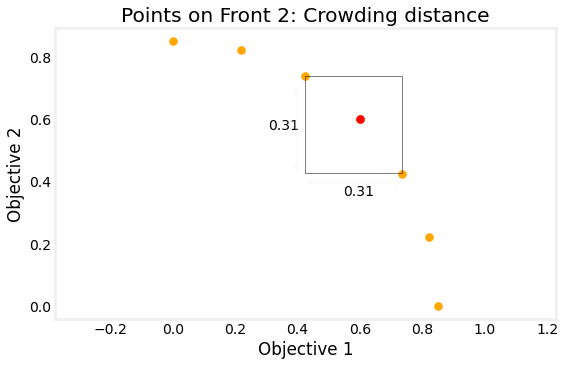

In [35]:
front2_idx = np.where(fronts == 1)[0]
fitness_front2 = fitness_values[front2_idx, :]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(fitness_front2[:, 0], fitness_front2[:, 1], s=64, c="orange")
ax.axis("equal")
ax.set_xlabel("Objective 1")
ax.set_ylabel("Objective 2")
ax.set_title("Points on Front 2: Crowding distance")

ax.scatter(fitness_front2[3, 0], fitness_front2[3, 1], s=64, c="red")
ax.add_patch(
    Rectangle(
        (fitness_front2[4, 0], fitness_front2[2, 1]),
        fitness_front2[2, 0] - fitness_front2[4, 0],
        fitness_front2[4, 1] - fitness_front2[2, 1],
        facecolor="None",
        edgecolor="k",
    )
)
ax.annotate(
    f"{fitness_front2[2, 0] - fitness_front2[4, 0]:.2f}",
    (fitness_front2[4, 0] + 0.12, fitness_front2[2, 1] - 0.07),
)
ax.annotate(
    f"{fitness_front2[4, 1] - fitness_front2[2, 1]:.2f}",
    (fitness_front2[4, 0] - 0.12, fitness_front2[4, 1] - 0.17),
)
ax.annotate(
    "",
    xy=(fitness_front2[4, 0], fitness_front2[2, 1] - 0.03),
    xytext=(fitness_front2[2, 0], fitness_front2[2, 1] - 0.03),
    arrowprops=dict(arrowstyle="<->"),
)
ax.annotate(
    "",
    xy=(fitness_front2[4, 0] - 0.03, fitness_front2[2, 1]),
    xytext=(fitness_front2[4, 0] - 0.03, fitness_front2[4, 1] - 0.03),
    arrowprops=dict(arrowstyle="<->"),
);

The red point has a total crowding distance of around 0.62 (i.e. 0.31 + 0.31). The two points at the edges of the front will have a crowding distance of infinity.

In [36]:
def crowding_distance(fitness, norm=True):
    n_obj = fitness.shape[1]
    population_size = fitness.shape[0]
    distance = np.zeros(population_size)
    for obj in range(n_obj):
        rank = np.argsort(fitness[:, obj])
        values = fitness[rank, obj]
        diff = values[2:] - values[:-2]
        if norm:
            distance[rank[1:-1]] += diff / (
                fitness[:, obj].max() - fitness[:, obj].min()
            )
        else:
            distance[rank[1:-1]] += diff
        distance[rank[[0, -1]]] += np.inf

    return distance

In [37]:
crowding_distance(fitness_front2, norm=False)

array([       inf, 0.53887841, 0.60104076, 0.62224319, 0.60104076,
       0.53887841,        inf])

Putting the non-dominated sorting and crowding distance together, these are the 10 solutions that would survive:

Text(0.5, 1.0, 'Solutions surviving to next generation')

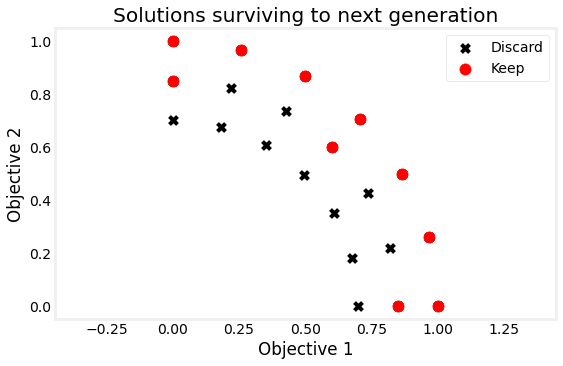

In [38]:
ranks = np.argsort(crowding_distance(fitness_front2))

plt.figure(figsize=(8, 5))
plt.scatter(x, y, c="k", marker="x", label="Discard", s=64)
plt.scatter(x[fronts == 0], y[fronts == 0], s=128, c="r", label="Keep")
plt.scatter(
    fitness_front2[ranks[-3:], 0],
    fitness_front2[ranks[-3:], 1],
    s=128,
    c="r",
)
plt.axis("equal")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("Solutions surviving to next generation")

### Crowding Tournament Selection

The previous discussion relates to _survival_ (which candidate solutions to keep to the next generation).

In NSGA-II we also use non-dominated sorting and crowding distance in _**selection**_ (picking pairs of parents to create children).

We'll still use _Tournament Selection_, but rather than the winner of each battle being the candidate with the highest fitness value, it will be the candidate with the lower _"**dominance-and-crowding rank**"_, defined as:

```
rank(a) < rank(b) if:
   - front(a) < front(b)
   - OR (front(a) == front(b)) AND (crowding(a) > crowding(b))
```

in other words, candidate `a` wins against candidate `b` if it's on a lower (more dominant) front, or is on the same front and has a higher crowding distance.

Everything else about the tournament selection stays the same, so we can inherit from the previous class and just overwrite the function that selects the winners in each battle:

In [39]:
class CrowdingTournamentSelection(TournamentSelection):
    def __init__(self, n_battles=None, n_per_battle=2):
        super().__init__(n_battles, n_per_battle)

    def _population_size(self, fronts_and_crowding):
        return len(fronts_and_crowding[0])

    def _select_winners(self, battle_idx, fronts_and_crowding):
        ranks = fronts_and_crowding[0][battle_idx]
        crowding = fronts_and_crowding[1][battle_idx]
        winners = []
        for i in range(len(battle_idx)):
            r = ranks[i, :]
            c = crowding[i, :]
            min_rank_idx = np.nonzero(r == r.min())[0]
            if len(min_rank_idx) == 1:
                # check whether single minimum rank, if so that's the winner
                winner = min_rank_idx[0]
            else:
                # if not, choose max crowding distance amongst those with minimum rank
                winner = min_rank_idx[c[min_rank_idx].argmin()]
            winners.append(winner)
        return np.array(winners)

## Hypervolume



The hypervolume (a.k.a. Lebesgue measure or S-metric) is a measure of the "volume" the candidate solutions cover in the multi-dimensional fitness/objective space.

Larger values are better, and in a hand wavy way can be achieved by the population having:
- Higher fitness values (across objectives) - rewards being closer to the Pareto front
- High diversity in fitness values - rewards having solutions that span different compromises (optimally: that span the Pareto front)

With 2 objectives the hypervolume becomes an approximated area, as shown below:

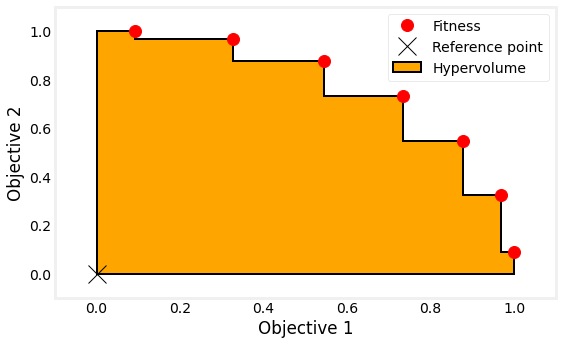

In [40]:
fv = (fitness_values[fronts == 0, :] + 0.1) / 1.1
fv = np.array(list(reversed(fv)))
plot_hypervolume(fv)

Example implementation (note how the hypervolume is smaller for the less dominant fronts seen in the previous example):

In [41]:
def hypervolume(scores, ref=np.array([0, 0])):
    scores = scores[scores[:, 0].argsort()]  # sort by 1st objective value
    diffs = np.diff(scores[:, 0], prepend=ref[0])  # deltas in 1st objective score
    return (diffs * (scores[:, 1] - ref[1])).sum()  # areas

In [42]:
for rank in range(fronts.max() + 1):
    print(f"Front {rank + 1} hypervolume", hypervolume(fitness_values[fronts == rank]))

Front 1 hypervolume 0.7106308865138644
Front 2 hypervolume 0.513430815506267
Front 3 hypervolume 0.34820913439179346


## NSGA-II

We now have everything we need for NSGA-II - we just need to adapt the genetic algorithm implementation from before to replace the survival and selection operators with ones based on non-dominated sorting and crowding distance.

As we want to preserve diversity in NSGA-II, we'll also add a function to guarantee the removal of any duplicate solutions that appear (even if it's a dominant duplicate).

In [43]:
class RemoveDuplicates:
    def __init__(self, decimals=None):
        self.decimals = decimals

    def apply(self, new_scores, new_population):
        if self.decimals is not None:
            new_scores = np.round(new_scores, decimals=self.decimals)
        keep_scores, keep_idx = np.unique(new_scores, return_index=True, axis=0)
        keep_population = new_population[keep_idx, :]

        return keep_scores, keep_population

In [44]:
class NSGA2(GeneticAlgorithm):
    def __init__(
        self,
        population,
        fitness,
        selection,
        crossover,
        mutation,
        duplicates=None,
        metrics=None,
    ):
        super().__init__(
            population,
            fitness,
            selection,
            crossover,
            mutation,
            duplicates=duplicates,
            metrics=metrics or hypervolume,
        )
        self.selection_scores = self._fronts_and_crowding()

    def _fronts_and_crowding(self):
        fronts = non_dominated_sort(self.fitness_scores)
        crowding = crowding_distance(self.fitness_scores)
        return [fronts, crowding]

    def _survival(self, new_scores):
        fronts = non_dominated_sort(new_scores, n_stop=self.population_size)
        last_front_rank = -1
        included = 0
        while included < self.population_size:
            last_front_rank += 1
            last_included = included
            included += (fronts == last_front_rank).sum()
        n_last_front = self.population_size - last_included

        # all solutions on first fronts survive (whilst number selected < population_size)
        survivors = [np.nonzero((fronts < last_front_rank) & (fronts >= 0))[0]]
        # on last included front, solutions with largest crowding distance survive
        last_front_idx = np.nonzero(fronts == last_front_rank)[0]

        if len(last_front_idx) == n_last_front:
            # special case where last front has exact number of solutions needed
            survivors.append(last_front_idx)
        else:
            distance = crowding_distance(new_scores[last_front_idx, :]).argsort()
            keep_idx = last_front_idx[distance[-n_last_front:]]
            survivors.append(keep_idx)

        survivors = np.concatenate(survivors)
        self.selection_scores = [
            fronts[survivors],
            crowding_distance(new_scores[survivors, :]),
        ]
        return survivors

    @property
    def max_fitness(self):
        return self.fitness_scores.max(axis=0)

    def champion(self, obj):
        return self.population[self.fitness_scores[:, obj].argmax(), :]

## Example: Quarter Circle

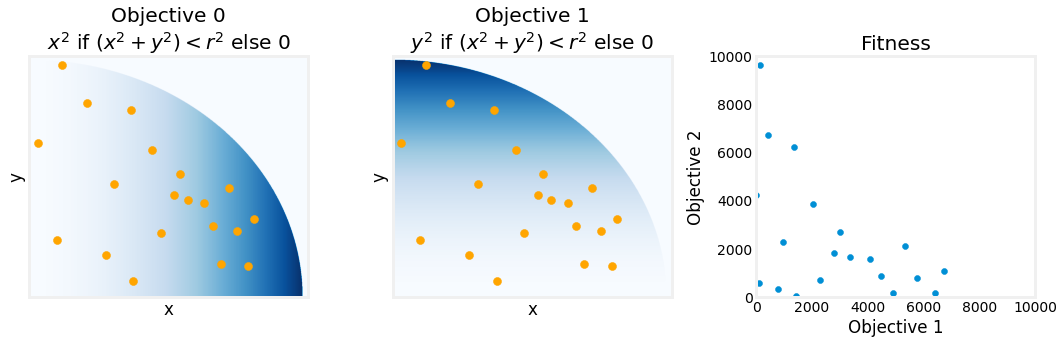

In [45]:
def circle_fitness(site_idx, radius):
    fit = site_idx**2
    fit[fit.sum(axis=1) > radius**2] = [0, 0]

    return fit


def rnd_init_circle(n, radius):
    r = radius * np.sqrt(np.random.uniform(0, 1, size=n))
    t = np.random.uniform(0, np.pi / 2, size=n)
    x = np.floor(r * np.cos(t))
    y = np.floor(r * np.sin(t))
    return np.array([x, y]).T


r = 100
pop = rnd_init_circle(20, r)
fitness_fn = partial(circle_fitness, radius=r)
plot_circle_fitness(pop, fitness_fn, r)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

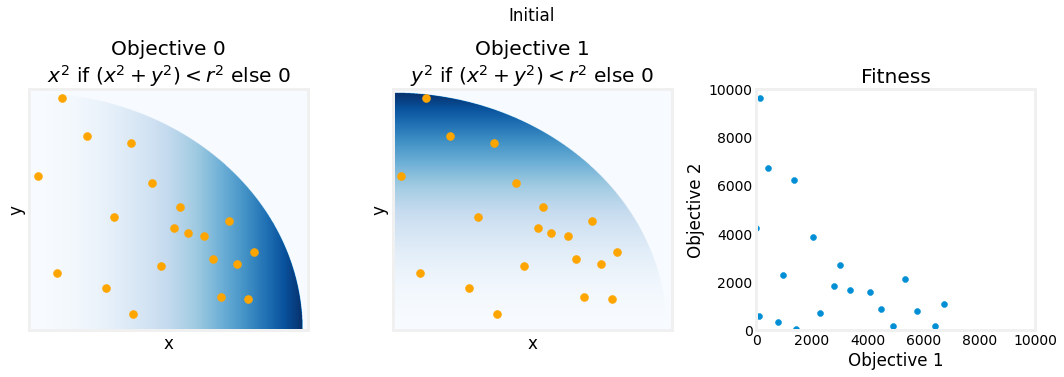

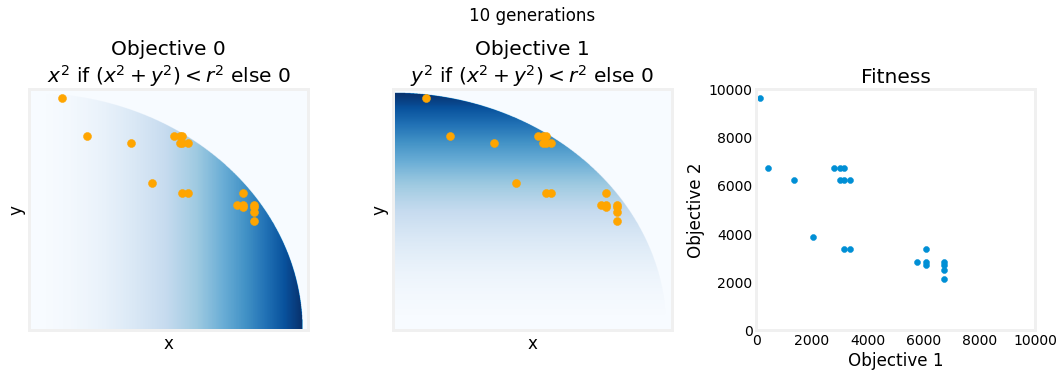

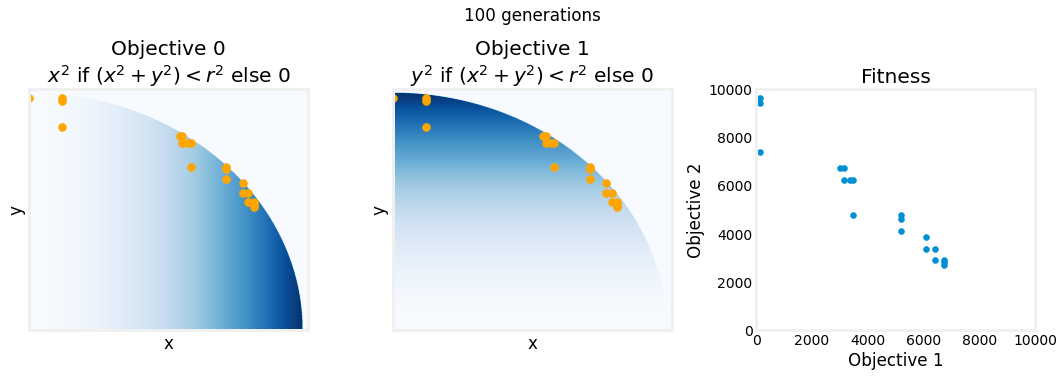

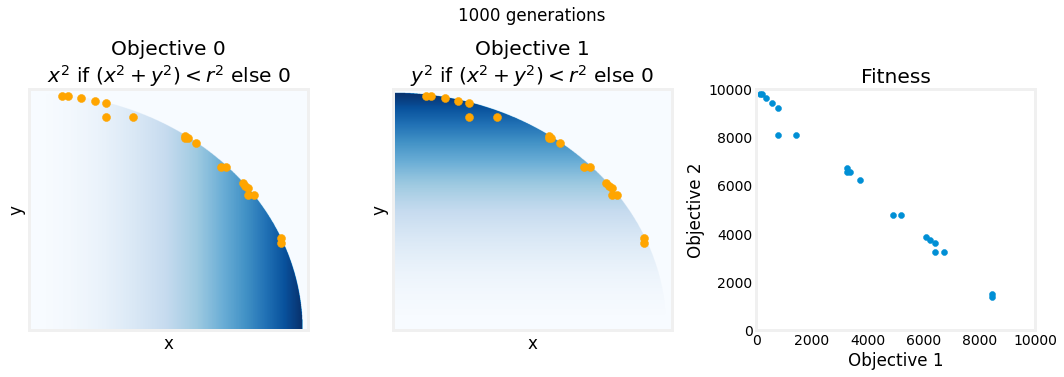

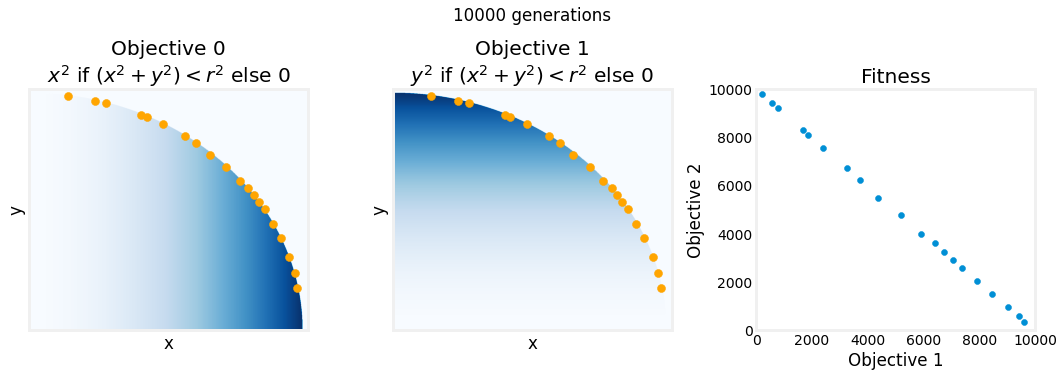

In [46]:
cts = CrowdingTournamentSelection()
spc = SinglePointCrossover()
um = UniformMutation(bounds=(0, r))
dups = RemoveDuplicates()
nsga = NSGA2(
    pop,
    fitness=fitness_fn,
    selection=cts,
    crossover=spc,
    mutation=um,
    duplicates=dups,
)

plot_circle_fitness(pop, fitness_fn, r, suptitle="Initial")

for gen in [10, 100, 1000, 10000]:
    nsga.run(gen)
    plot_circle_fitness(nsga.population, fitness_fn, r, suptitle=f"{gen} generations")

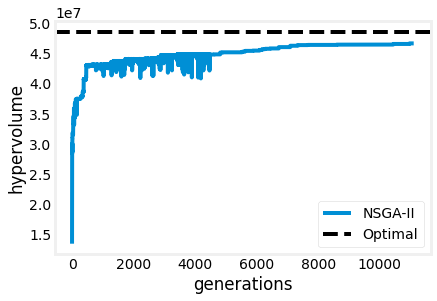

In [47]:
t = np.linspace(0, np.pi / 2, 10000)
x = r * np.cos(t)
y = r * np.sin(t)
cf = fitness_fn(np.array([np.round(x), np.round(y)]).T)
select = (cf**2).sum(axis=1) > 0

plt.plot(nsga.metrics_log, label="NSGA-II")
plt.ylabel("hypervolume")
plt.xlabel("generations")
plt.axhline(hypervolume(cf[select, :]), color="k", linestyle="--", label="Optimal")
plt.legend()

## Back to Camden

Goal:
- Find "Pareto optimal" placements for 20 ice cream stands in Camden that consider compromises between coverage of residents over 65, and of workplaces.

In [48]:
population_size = 200  # Number of candidate ice cream stand placements to generate
n_oa = len(oa_stats)  # Number of potential ice cream stand sites
n_ice_cream = 20  # Number of ice cream stands that we're going to place around Camden

pop = init_population((population_size, n_ice_cream), (0, n_oa))

In [49]:
radius = 300  # Everyone within this many metres is a customer!
cl = CoveredLocations(
    oa_stats[["x", "y"]].values,
    radius,
    weights=np.array([oa_stats["over65"].values, oa_stats["workers"].values]).T,
)

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0, 0.5, 'Workers')

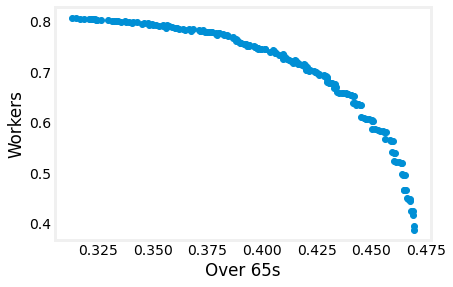

In [50]:
cts = CrowdingTournamentSelection()
spc = SinglePointCrossover(prob=0.95)
um = UniformMutation(bounds=(0, n_oa))
dups = RemoveDuplicates()

nsga = NSGA2(
    pop,
    fitness=cl.fitness,
    selection=cts,
    crossover=spc,
    mutation=um,
    duplicates=dups,
)
nsga.run(5000)

plt.plot(nsga.fitness_scores[:, 0], nsga.fitness_scores[:, 1], "o")
plt.xlabel("Over 65s")
plt.ylabel("Workers")

As expected, since workers and the over 65s have different distributions in the borough, increasing coverage of (providing more ice cream to) one group necessitates decreasing coverage of the other.

As workers are more concentrated you can "cover more of them with ice cream" than the Over 65s (given the same number of stands).

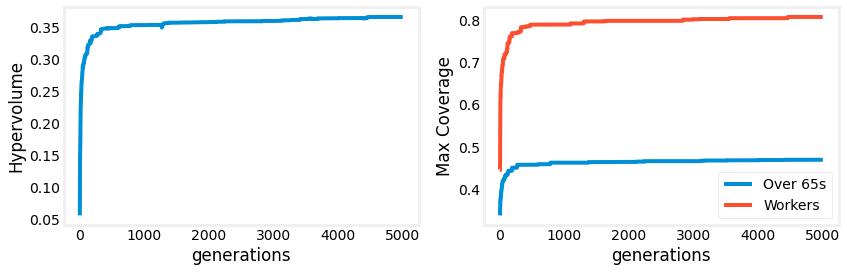

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(nsga.metrics_log)
ax[0].set_ylabel("Hypervolume")
ax[0].set_xlabel("generations")

ax[1].plot(np.array(nsga.fitness_log)[:, 0], label="Over 65s")
ax[1].plot(np.array(nsga.fitness_log)[:, 1], label="Workers")
ax[1].legend()
ax[1].set_xlabel("generations")
ax[1].set_ylabel("Max Coverage")

fig.tight_layout()

Here are the two solutions with the maximum coverage of over 65s and workers:

Text(0.5, 1.0, 'Max Workers\nCoverage: Over 65s 0.31, Workers 0.81')

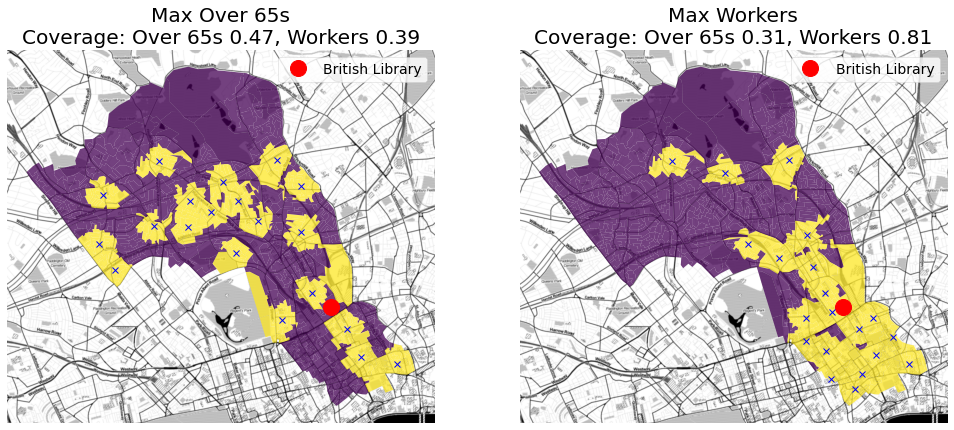

In [52]:
champion = nsga.fitness_scores.argmax(0)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
plot_oa(cl.covered_points(nsga.champion(0)), ax=ax[0])
ax[0].plot(
    oa_stats["x"].values[nsga.champion(0)], oa_stats["y"].values[nsga.champion(0)], "bx"
)
ax[0].set_title(
    f"Max Over 65s\nCoverage: Over 65s {nsga.fitness_scores[champion[0], 0]:.2f}, Workers {nsga.fitness_scores[champion[0], 1]:.2f}"
)

plot_oa(cl.covered_points(nsga.champion(1)), ax=ax[1])
ax[1].plot(
    oa_stats["x"].values[nsga.champion(1)], oa_stats["y"].values[nsga.champion(1)], "bx"
)
ax[1].set_title(f"Max Workers\n{nsga.fitness_scores[champion[1], :]}")
ax[1].set_title(
    f"Max Workers\nCoverage: Over 65s {nsga.fitness_scores[champion[1], 0]:.2f}, Workers {nsga.fitness_scores[champion[1], 1]:.2f}"
)

## References/Links

### Python Packages

Couple of libraries that have full implementations of NSGA-II and other (single- and multi-objective) algorithms:

- pygmo: https://esa.github.io/pygmo2

- pymoo: https://pymoo.org/

### Papers & Articles

- Genetic Algorithms
   - ...
- NSGA-II
   - [_A Fast and Elitist Multiobjective Genetic Algorithm: NSGA-II_, Kalyanmoy Deb, Associate Member, IEEE, Amrit Pratap, Sameer Agarwal, and T. Meyarivan, 182 IEEE Transactions ON Evolutionary Computation, Vol. 6, No. 2, 2002](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.542.385&rep=rep1&type=pdf)
- Maximum Coverage Location Problems
   - https://en.wikipedia.org/wiki/Maximum_coverage_problem
   
### Datasets

- ONS

